In [61]:
import numpy as np
import pandas as pd
import optuna
import lightgbm as lgb
from mlforecast import MLForecast
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [62]:
# Load the data
train_df = pd.read_csv("../output/0_data_cleaning/lightgbm_2014/train_lightgbm_2014.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})
test_df = pd.read_csv("../output/0_data_cleaning/lightgbm_2014/test_lightgbm_2014.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})

In [63]:
train_df

,year,country,population,gdp,temperature_change_from_co2,cement_co2_lag_1,cement_co2_lag_2,cement_co2_lag_3,coal_co2_lag_1,coal_co2_lag_2,...,gas_co2_lag_1,gas_co2_lag_2,gas_co2_lag_3,land_use_change_co2_lag_1,land_use_change_co2_lag_2,land_use_change_co2_lag_3,oil_co2_lag_1,oil_co2_lag_2,oil_co2_lag_3,co2
0,1931,Argentina,0.007077,0.004340,0.018519,0.000264,0.000246,0.000181,0.001088,0.001138,...,0.000331,0.000349,0.000230,0.130852,0.145747,0.145501,0.001516,0.001581,0.001529,0.034449
1,1932,Argentina,0.007252,0.004193,0.018519,0.000371,0.000267,0.000272,0.000931,0.001111,...,0.000411,0.000346,0.000355,0.121032,0.130852,0.145747,0.001917,0.001516,0.001581,0.032754
2,1933,Argentina,0.007409,0.004394,0.018519,0.000346,0.000374,0.000296,0.000848,0.000950,...,0.000560,0.000430,0.000352,0.115574,0.121032,0.130852,0.002177,0.001917,0.001516,0.031597
3,1934,Argentina,0.007569,0.004754,0.018519,0.000355,0.000349,0.000414,0.000798,0.000866,...,0.000754,0.000587,0.000437,0.111860,0.115574,0.121032,0.002265,0.002177,0.001917,0.030857
4,1935,Argentina,0.007731,0.004969,0.018519,0.000392,0.000358,0.000386,0.000882,0.000815,...,0.000910,0.000789,0.000596,0.109199,0.111860,0.115574,0.002320,0.002265,0.002177,0.030160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,2009,Vietnam,0.061301,0.024047,0.018519,0.021493,0.019847,0.019165,0.005846,0.004988,...,0.010131,0.009521,0.008688,0.107045,0.110075,0.102111,0.015295,0.014136,0.012265,0.048437
3455,2010,Vietnam,0.061976,0.025535,0.018519,0.026916,0.021682,0.021987,0.006094,0.005970,...,0.011205,0.010606,0.009670,0.130652,0.107045,0.110075,0.016400,0.015295,0.014136,0.044151
3456,2011,Vietnam,0.062659,0.027067,0.018519,0.033255,0.027152,0.024020,0.006358,0.006223,...,0.013155,0.011730,0.010772,0.112360,0.130652,0.107045,0.018656,0.016400,0.015295,0.043697
3457,2012,Vietnam,0.063352,0.028564,0.023148,0.039485,0.033547,0.030080,0.007977,0.006493,...,0.011865,0.013770,0.011913,0.106872,0.112360,0.130652,0.017852,0.018656,0.016400,0.042866


In [64]:
test_df

,year,country,population,gdp,temperature_change_from_co2,cement_co2_lag_1,cement_co2_lag_2,cement_co2_lag_3,coal_co2_lag_1,coal_co2_lag_2,...,gas_co2_lag_1,gas_co2_lag_2,gas_co2_lag_3,land_use_change_co2_lag_1,land_use_change_co2_lag_2,land_use_change_co2_lag_3,oil_co2_lag_1,oil_co2_lag_2,oil_co2_lag_3,co2
0,2014,Argentina,0.029522,0.051222,0.046296,0.006409,0.005905,0.007170,0.000648,0.000685,...,0.066569,0.072771,0.071745,0.111846,0.129786,0.156223,0.033105,0.032386,0.032886,0.046557
1,2015,Argentina,0.029837,0.052624,0.050926,0.006066,0.006465,0.006542,0.000742,0.000662,...,0.067667,0.069686,0.073910,0.104790,0.111846,0.129786,0.031896,0.033105,0.032386,0.046434
2,2016,Argentina,0.030136,0.051527,0.050926,0.006395,0.006119,0.007162,0.000732,0.000757,...,0.068171,0.070835,0.070777,0.103356,0.104790,0.111846,0.032904,0.031896,0.033105,0.044811
3,2017,Argentina,0.030418,0.052983,0.050926,0.005637,0.006451,0.006779,0.000562,0.000748,...,0.070188,0.071362,0.071944,0.098775,0.103356,0.104790,0.031996,0.032904,0.031896,0.043281
4,2018,Argentina,0.030679,0.051593,0.050926,0.006103,0.005686,0.007147,0.000573,0.000573,...,0.070289,0.073474,0.072480,0.094860,0.098775,0.103356,0.030596,0.031996,0.032904,0.041428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,2018,Vietnam,0.067438,0.042150,0.023148,0.059787,0.051967,0.053625,0.014498,0.014618,...,0.013029,0.015540,0.015857,0.153375,0.122911,0.140180,0.022354,0.021793,0.023108,0.067964
401,2019,Vietnam,0.068066,0.045261,0.027778,0.069444,0.060312,0.057571,0.016360,0.014805,...,0.013523,0.013639,0.015783,0.151128,0.153375,0.122911,0.024988,0.022354,0.021793,0.076314
402,2020,Vietnam,0.068700,0.046562,0.027778,0.079098,0.070053,0.066816,0.025646,0.016707,...,0.013779,0.014156,0.013853,0.151447,0.151128,0.153375,0.027793,0.024988,0.022354,0.078594
403,2021,Vietnam,0.069297,0.047758,0.027778,0.084034,0.079792,0.077607,0.028911,0.026190,...,0.012340,0.014424,0.014377,0.151971,0.151447,0.151128,0.026213,0.027793,0.024988,0.077848


In [65]:
# Ensure that 'country' is treated as a string
train_df['country'] = train_df['country'].astype(str)
test_df['country'] = test_df['country'].astype(str)

# Set up the lags
max_lag = 2  # Adjust as necessary
lags = [2, 3]#list(range(1, max_lag + 1))

# Initialize the model with best hyperparameters
best_model = lgb.LGBMRegressor(
    max_depth=3,
    num_leaves=60,
    min_data_in_leaf=50, 
    random_state=0,
    verbosity=-1,
    #lambda_l1=2.0,
    #lambda_l2=6.0,
    #feature_fraction =0.9,
    #learning_rate = 0.05,
    #objective='rmse'
)

# Initialize MLForecast with the best model
forecast_model = MLForecast(
    models=[best_model],
    freq=1,
    #lags=lags,
    date_features=None,
    num_threads=2
)

# Fit the model on the entire training data
forecast_model.fit(
    train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[],
    fitted=True
)

MLForecast(models=[LGBMRegressor], freq=1, lag_features=[], date_features=[], num_threads=2)

In [66]:
# Transform the data to create lagged features
train_transformed = forecast_model.preprocess(
    df=train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[]
)

train_transformed

,year,country,population,gdp,temperature_change_from_co2,cement_co2_lag_1,cement_co2_lag_2,cement_co2_lag_3,coal_co2_lag_1,coal_co2_lag_2,...,gas_co2_lag_1,gas_co2_lag_2,gas_co2_lag_3,land_use_change_co2_lag_1,land_use_change_co2_lag_2,land_use_change_co2_lag_3,oil_co2_lag_1,oil_co2_lag_2,oil_co2_lag_3,co2
0,1931,Argentina,0.007077,0.004340,0.018519,0.000264,0.000246,0.000181,0.001088,0.001138,...,0.000331,0.000349,0.000230,0.130852,0.145747,0.145501,0.001516,0.001581,0.001529,0.034449
1,1932,Argentina,0.007252,0.004193,0.018519,0.000371,0.000267,0.000272,0.000931,0.001111,...,0.000411,0.000346,0.000355,0.121032,0.130852,0.145747,0.001917,0.001516,0.001581,0.032754
2,1933,Argentina,0.007409,0.004394,0.018519,0.000346,0.000374,0.000296,0.000848,0.000950,...,0.000560,0.000430,0.000352,0.115574,0.121032,0.130852,0.002177,0.001917,0.001516,0.031597
3,1934,Argentina,0.007569,0.004754,0.018519,0.000355,0.000349,0.000414,0.000798,0.000866,...,0.000754,0.000587,0.000437,0.111860,0.115574,0.121032,0.002265,0.002177,0.001917,0.030857
4,1935,Argentina,0.007731,0.004969,0.018519,0.000392,0.000358,0.000386,0.000882,0.000815,...,0.000910,0.000789,0.000596,0.109199,0.111860,0.115574,0.002320,0.002265,0.002177,0.030160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,2009,Vietnam,0.061301,0.024047,0.018519,0.021493,0.019847,0.019165,0.005846,0.004988,...,0.010131,0.009521,0.008688,0.107045,0.110075,0.102111,0.015295,0.014136,0.012265,0.048437
3455,2010,Vietnam,0.061976,0.025535,0.018519,0.026916,0.021682,0.021987,0.006094,0.005970,...,0.011205,0.010606,0.009670,0.130652,0.107045,0.110075,0.016400,0.015295,0.014136,0.044151
3456,2011,Vietnam,0.062659,0.027067,0.018519,0.033255,0.027152,0.024020,0.006358,0.006223,...,0.013155,0.011730,0.010772,0.112360,0.130652,0.107045,0.018656,0.016400,0.015295,0.043697
3457,2012,Vietnam,0.063352,0.028564,0.023148,0.039485,0.033547,0.030080,0.007977,0.006493,...,0.011865,0.013770,0.011913,0.106872,0.112360,0.130652,0.017852,0.018656,0.016400,0.042866


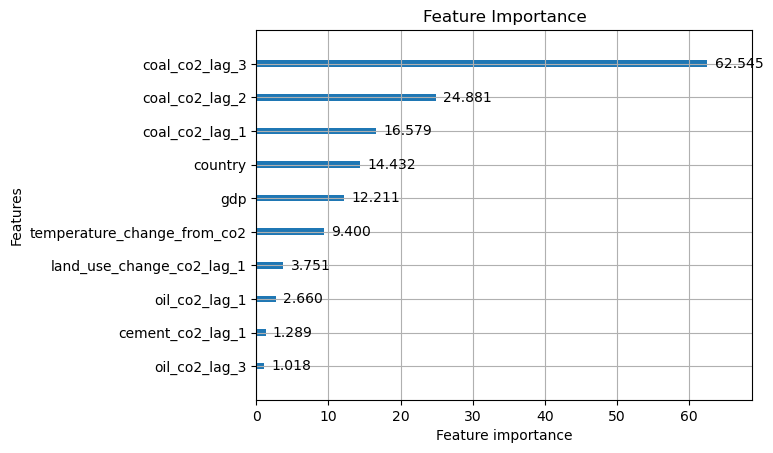

In [67]:
# Separate features and target
X_train = train_transformed.drop(columns=['co2'])
y_train = train_transformed['co2']

# Convert 'country' to a categorical feature
X_train['country'] = X_train['country'].astype('category')

# Fit the LightGBM model
best_model.fit(X_train, y_train, categorical_feature=['country'])

# Plot feature importance
lgb.plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance')
plt.show()

In [68]:
#TRAIN DATA
# Get the fitted values on the training data
fitted_values = forecast_model.forecast_fitted_values()

# Rename 'LGBMRegressor' to 'co2_predicted'
fitted_values = fitted_values.rename(columns={'LGBMRegressor': 'co2_predicted'})

# Merge fitted values with actual values
results_train = fitted_values.merge(
    train_df[['country', 'year', 'co2']],
    on=['country', 'year', 'co2'],
    how='left'
)

# Rename 'co2' to 'co2_actual'
results_train = results_train.rename(columns={'co2': 'co2_actual'})

# Drop any rows with NaNs
results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

# Calculate the Mean Absolute Percentage Error (MAPE) on the training set
train_mape = mean_absolute_percentage_error(results_train['co2_actual'], results_train['co2_predicted'])
print(f"Train MAPE: {train_mape}")

Train MAPE: 34509372855.95445


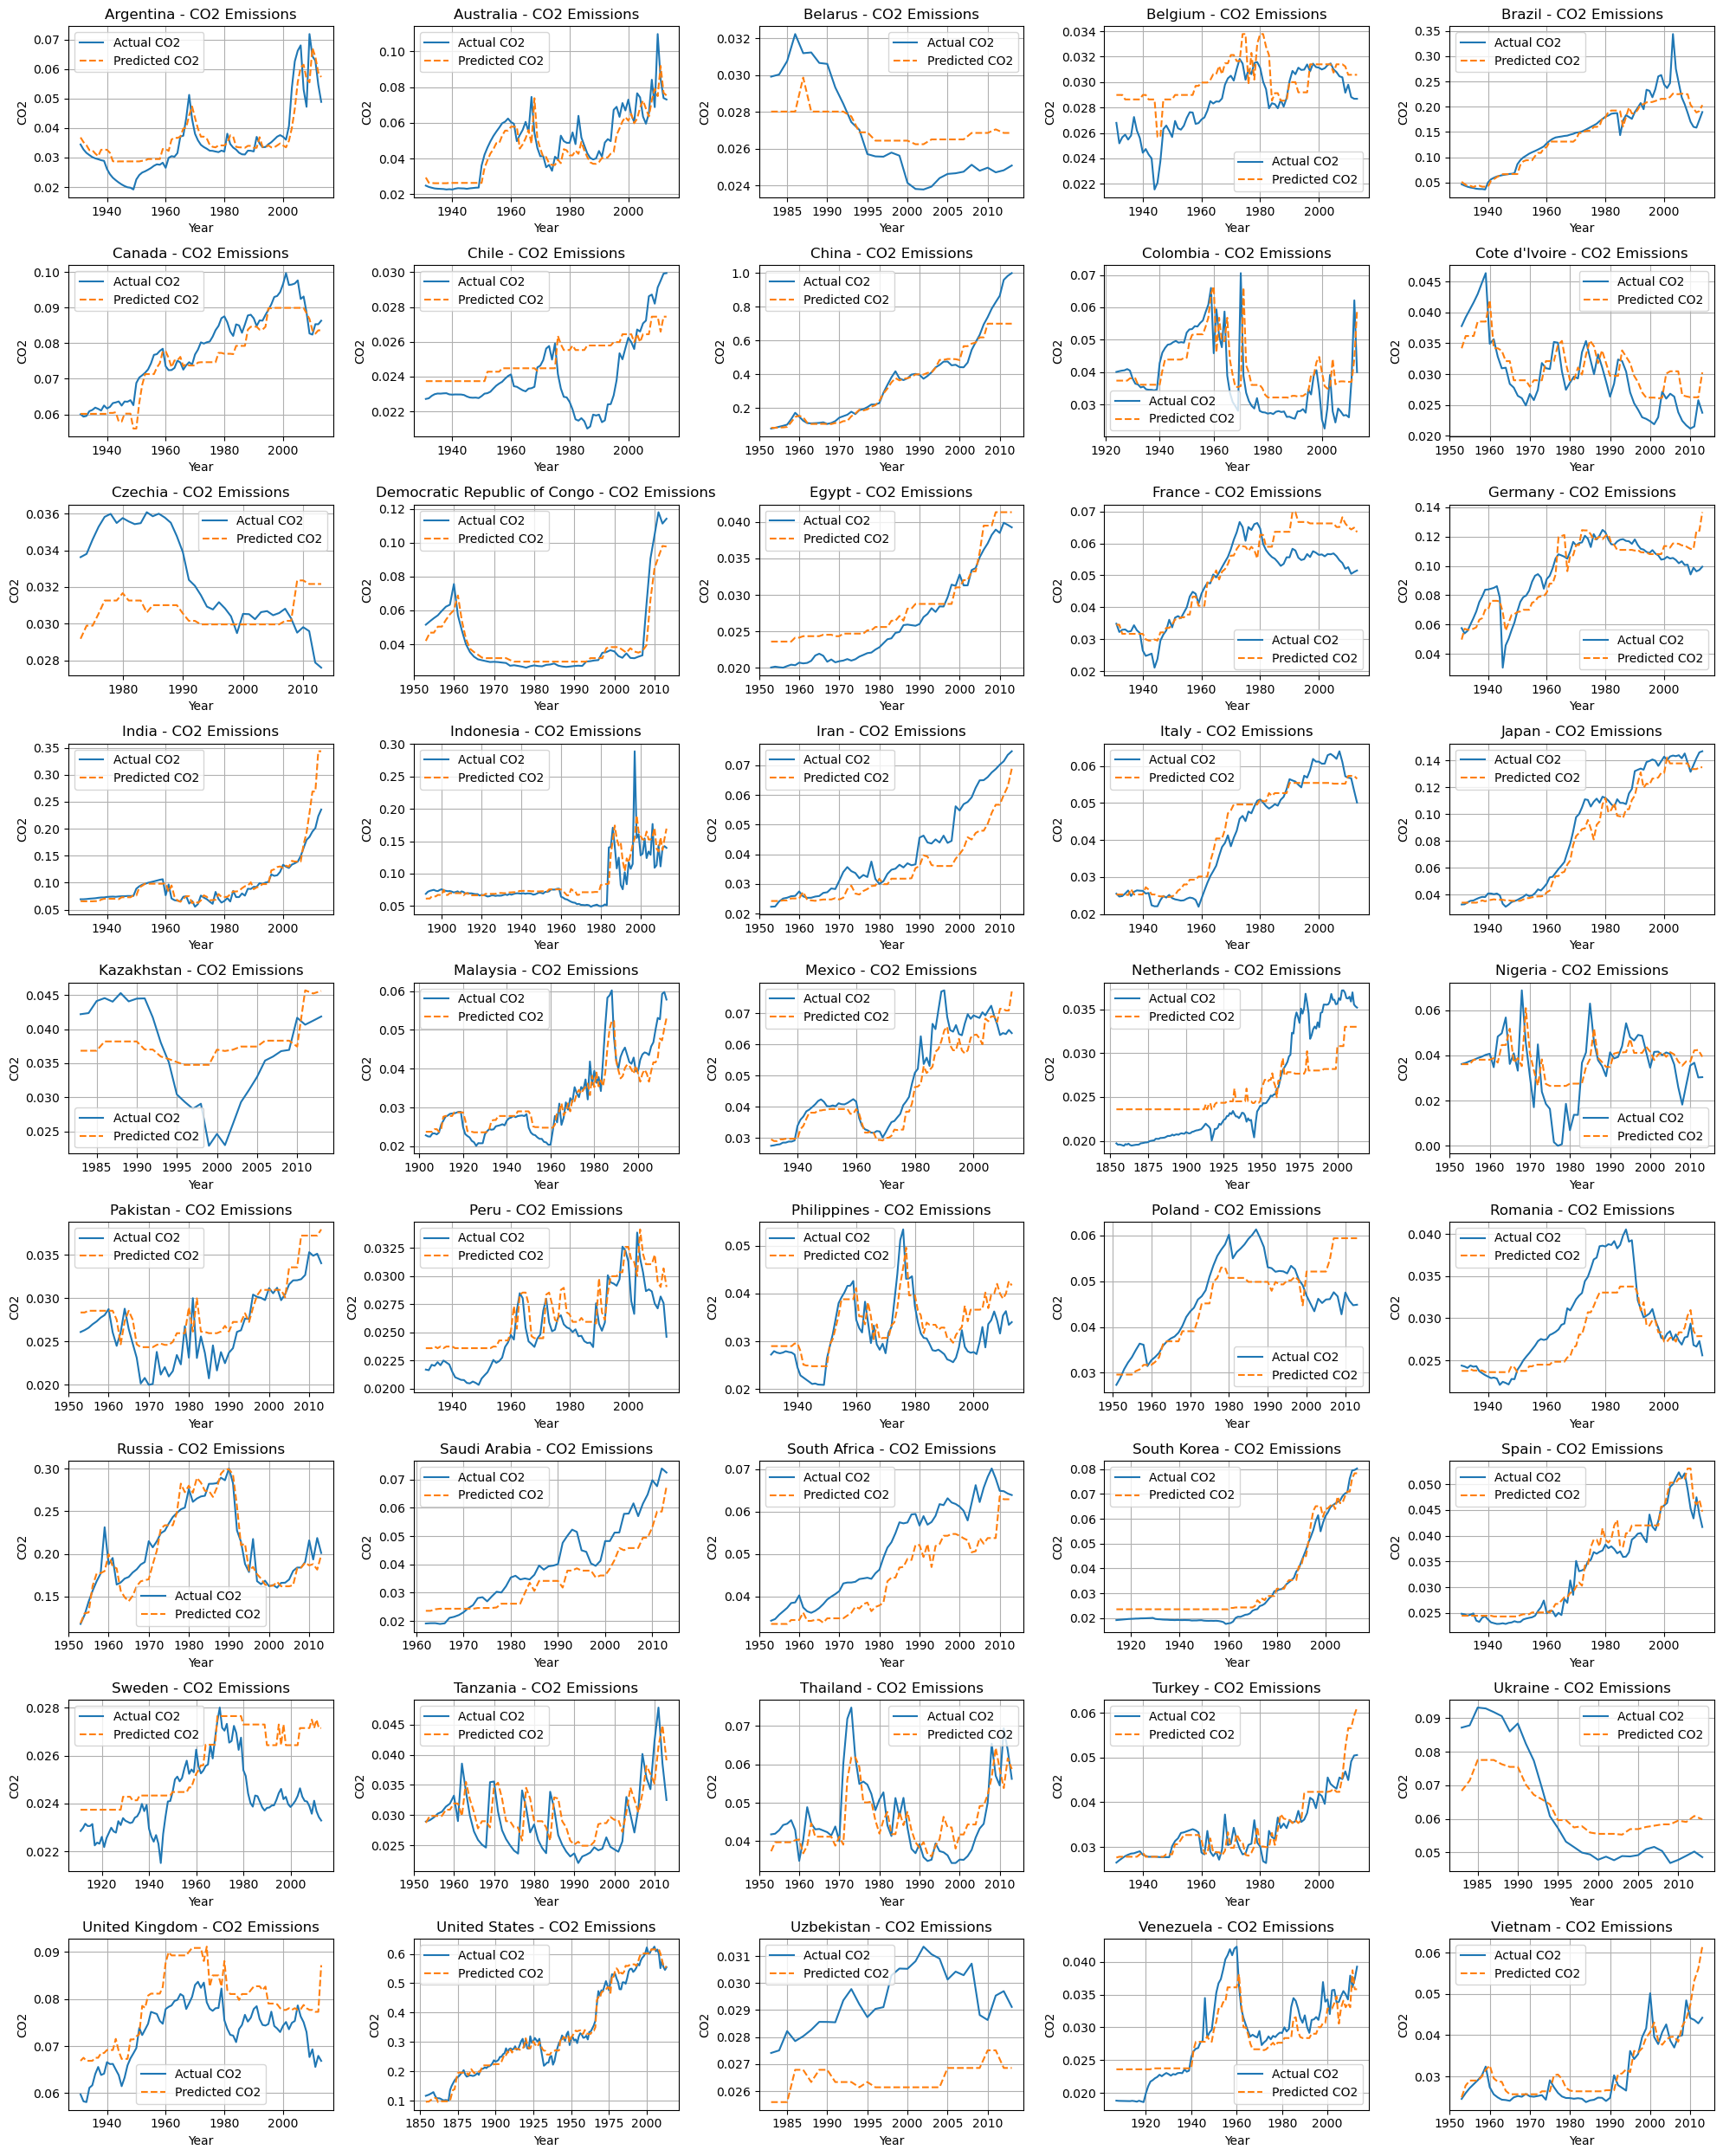

In [69]:
#TRAIN DATA
# Define the layout for subplots
num_rows = 9
num_cols = 5
countries = results_train['country'].unique()  # Get unique countries

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_train[results_train['country'] == country]
    ax = axes[i]
    
    # Plot the actual and predicted CO2 for each country
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [70]:
#TEST DATA
# Set the prediction horizon to 9 years (from 2014 to 2022)
horizon = 9

# Prepare the test features by removing the target column to avoid leakage
test_features = test_df.drop(columns=['co2'])

# Make predictions for all countries at once over the 9-year horizon
predictions_df = forecast_model.predict(h=horizon, X_df=test_features)

# Rename the predicted column for clarity
predictions_df = predictions_df.rename(columns={'LGBMRegressor': 'co2_predicted'})

# Merge predictions with actual values from the test set for comparison
results_test = predictions_df.merge(
    test_df[['country', 'year', 'co2']],
    on=['country', 'year'],
    how='left'
).rename(columns={'co2': 'co2_actual'})

# Display the first few rows of the predictions vs actuals
print(results_test)

# Calculate the Mean Absolute Percentage Error (MAPE) for the test set
mape = mean_absolute_percentage_error(results_test['co2_actual'], results_test['co2_predicted'])
print(f"Test MAPE: {mape}")

       country  year  co2_predicted  co2_actual
0    Argentina  2014       0.053682    0.046557
1    Argentina  2015       0.056279    0.046434
2    Argentina  2016       0.056279    0.044811
3    Argentina  2017       0.056279    0.043281
4    Argentina  2018       0.056279    0.041428
..         ...   ...            ...         ...
400    Vietnam  2018       0.071299    0.067964
401    Vietnam  2019       0.084320    0.076314
402    Vietnam  2020       0.074246    0.078594
403    Vietnam  2021       0.077499    0.077848
404    Vietnam  2022       0.079558    0.076854

[405 rows x 4 columns]
Test MAPE: 0.20792100753251797


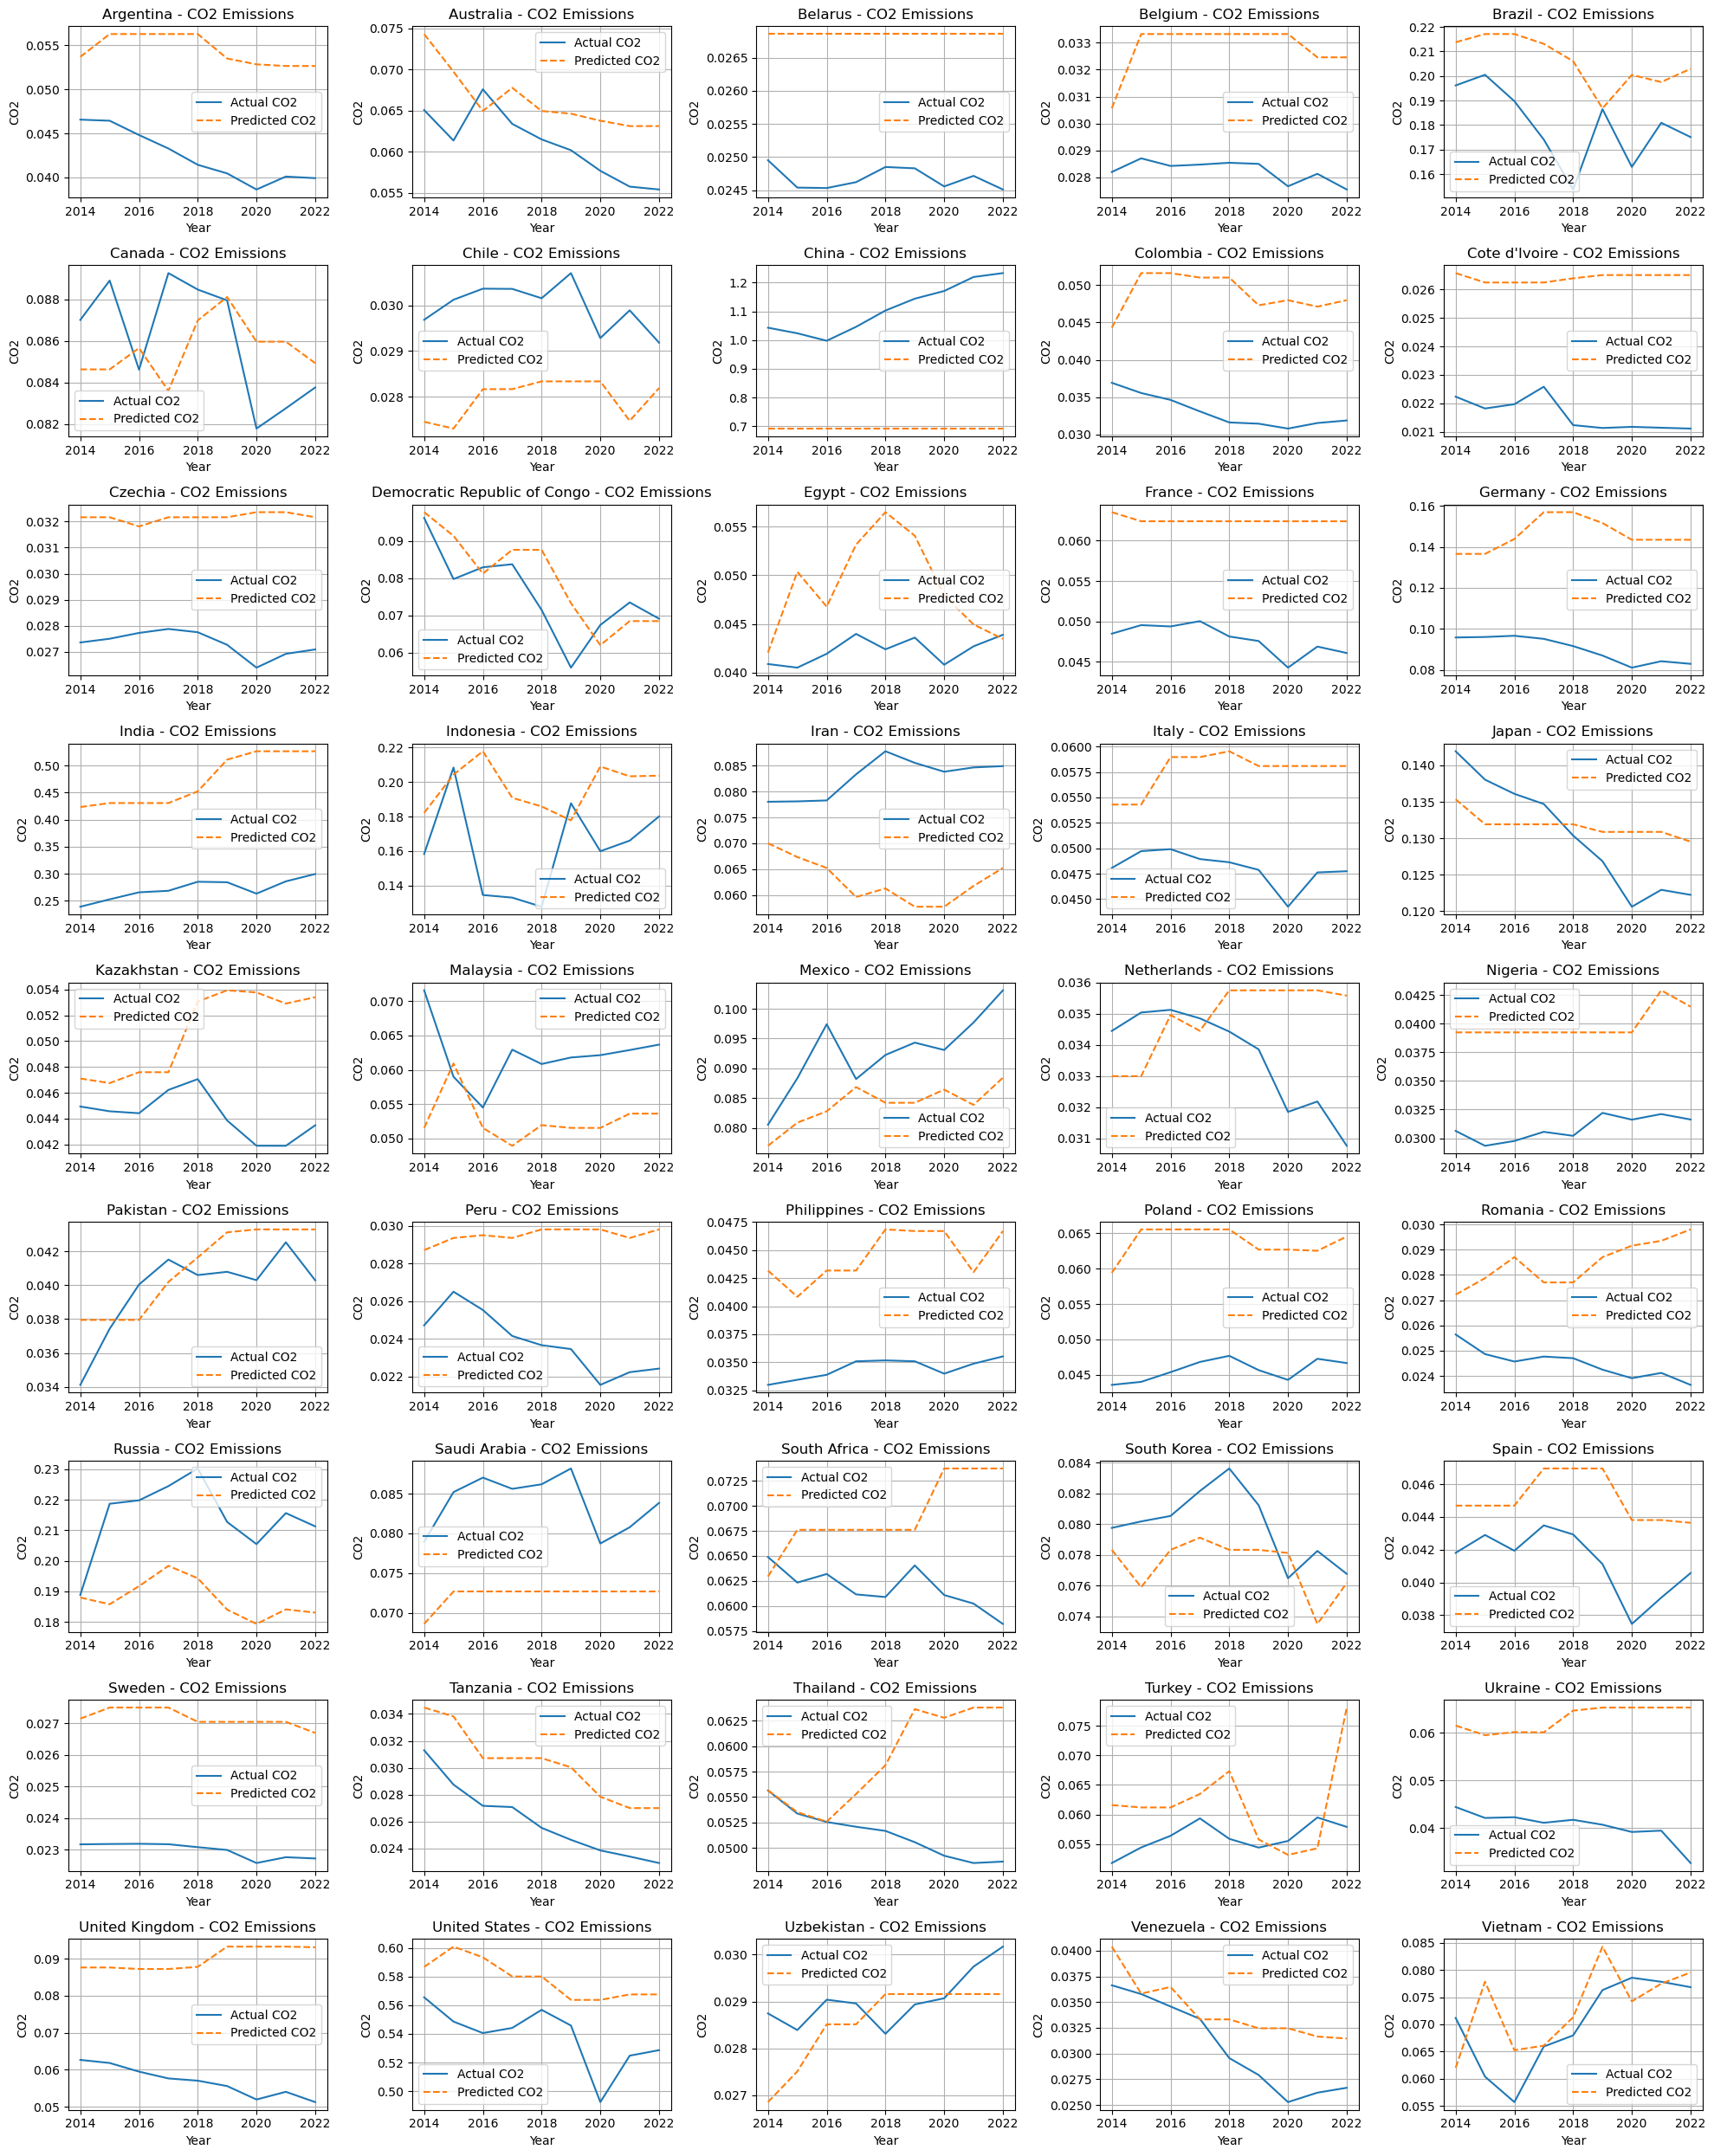

In [71]:
#TEST DATA
# Define the layout for subplots
num_rows = 9
num_cols = 5
countries = results_test['country'].unique()  # Get unique countries

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_test[results_test['country'] == country]
    ax = axes[i]
    
    # Plot the actual and predicted CO2 for each country
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

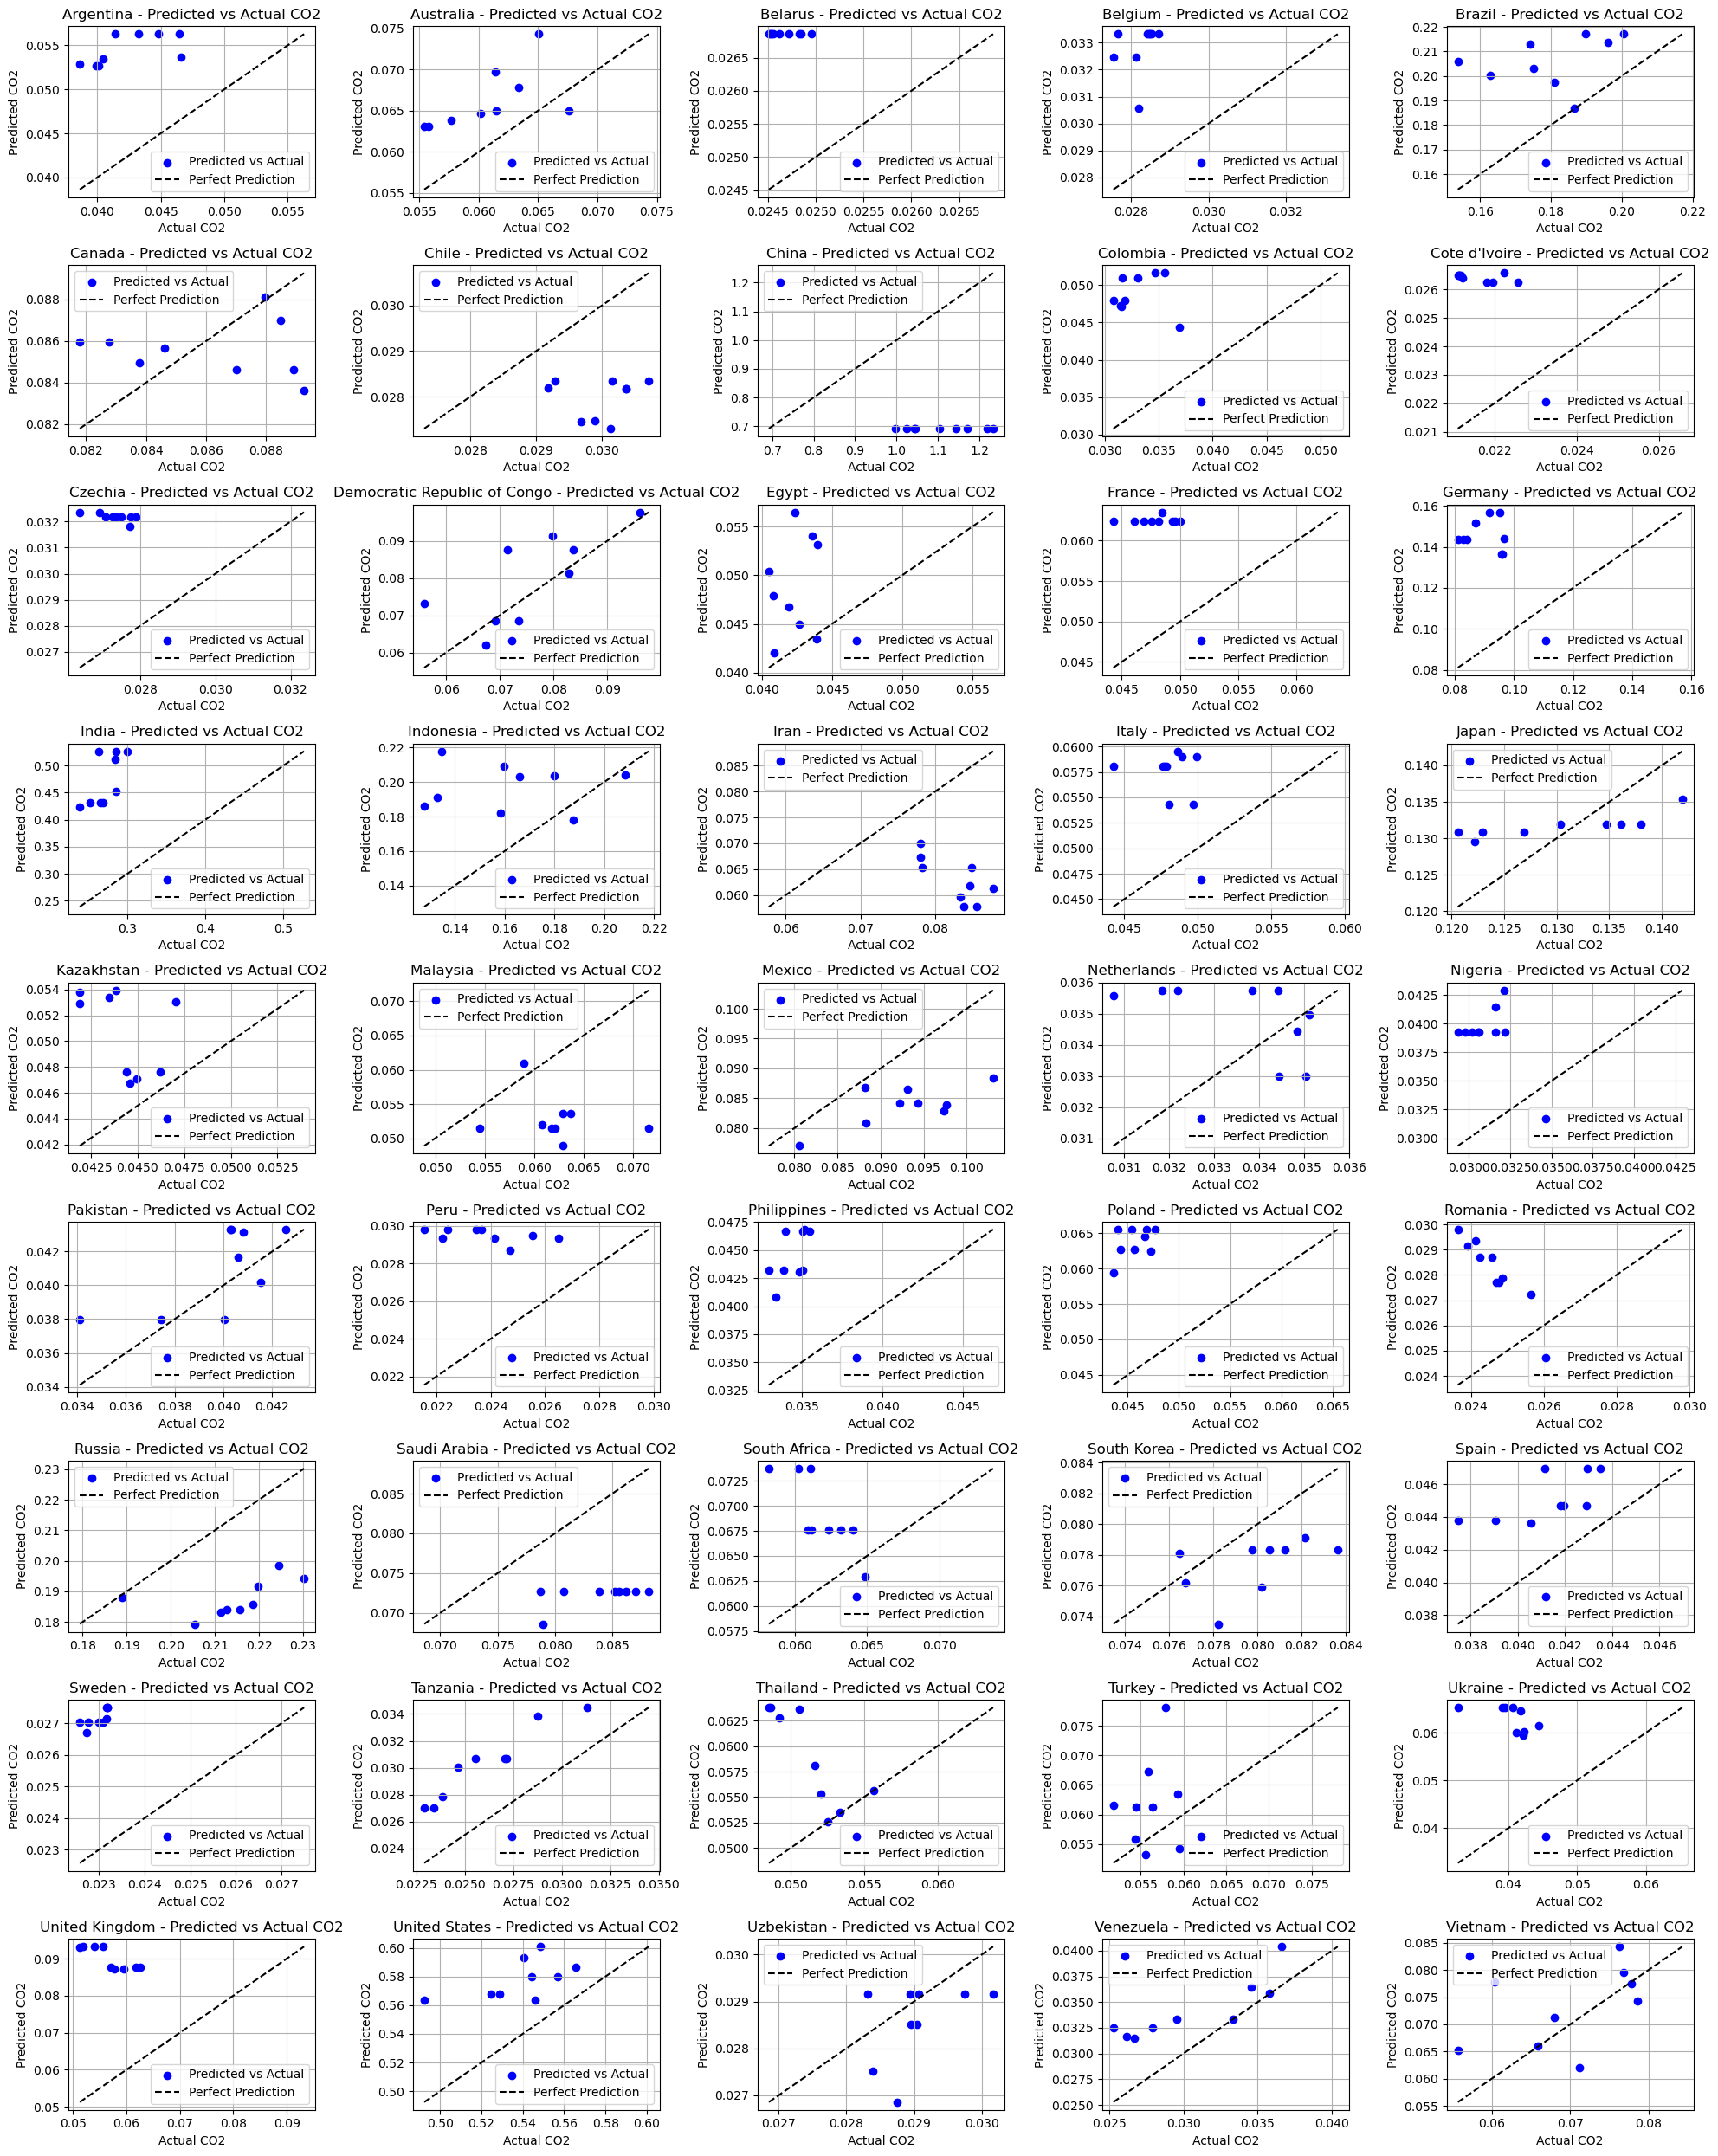

In [72]:
# Define the layout for subplots
countries = results_test['country'].unique()  # Get unique countries
num_countries = len(countries)
num_cols = 5
num_rows = (num_countries - 1) // num_cols + 1

# Create a figure for scatter plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_test[results_test['country'] == country]
    ax = axes[i]
    
    # Scatter plot: actual values as x and predicted values as y
    ax.scatter(country_results['co2_actual'], country_results['co2_predicted'], color='blue', label='Predicted vs Actual')
    
    # Add a reference line (y = x) to indicate perfect prediction
    min_val = min(country_results['co2_actual'].min(), country_results['co2_predicted'].min())
    max_val = max(country_results['co2_actual'].max(), country_results['co2_predicted'].max())
    ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', label='Perfect Prediction')
    
    ax.set_title(f'{country} - Predicted vs Actual CO2')
    ax.set_xlabel('Actual CO2')
    ax.set_ylabel('Predicted CO2')
    ax.grid(True)
    ax.legend()

# Hide any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and save the figure
plt.tight_layout()

# Show the plot (optional)
plt.show()

# Close the plot to free up memory
plt.close(fig)